<a href="https://colab.research.google.com/github/inachenyx/CompressedSensing/blob/main/Reconstruct_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download sample ephys data via wget from the raw file link
!wget https://gin.g-node.org/NeuralEnsemble/ephy_testing_data/raw/master/mearec/mearec_test_10s.h5

--2025-05-19 12:26:20--  https://gin.g-node.org/NeuralEnsemble/ephy_testing_data/raw/master/mearec/mearec_test_10s.h5
Resolving gin.g-node.org (gin.g-node.org)... 141.84.41.219
Connecting to gin.g-node.org (gin.g-node.org)|141.84.41.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62317832 (59M) [application/octet-stream]
Saving to: ‘mearec_test_10s.h5.1’

mearec_test_10s.h5. 100%[===================>]  59.43M   661KB/s    in 2m 24s  

2025-05-19 12:28:45 (422 KB/s) - ‘mearec_test_10s.h5.1’ saved [62317832/62317832]



In [ ]:
# ! pip install spikeinterface

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
import h5py
from scipy.signal import butter, filtfilt

# import spikeinterface.extractors as se
# import spikeinterface.preprocessing as spre
# import spikeinterface.widgets as sw

## Read with h5py

In [ ]:
def print_hdf5_structure(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(f"{name} --> Dataset, shape: {obj.shape}, dtype: {obj.dtype}")
    elif isinstance(obj, h5py.Group):
        print(f"{name} --> Group")

with h5py.File("mearec_test_10s.h5", "r") as f:
    f.visititems(print_hdf5_structure)

channel_positions --> Dataset, shape: (32, 3), dtype: float64
info --> Group
info/cell_types --> Group
info/cell_types/excitatory --> Dataset, shape: (3,), dtype: |S2
info/cell_types/inhibitory --> Dataset, shape: (8,), dtype: |S3
info/electrodes --> Group
info/electrodes/dim --> Dataset, shape: (3,), dtype: int64
info/electrodes/electrode_name --> Dataset, shape: (), dtype: object
info/electrodes/pitch --> Dataset, shape: (2,), dtype: float64
info/electrodes/shape --> Dataset, shape: (), dtype: object
info/electrodes/size --> Dataset, shape: (), dtype: float64
info/electrodes/sortlist --> Dataset, shape: (), dtype: object
info/electrodes/stagger --> Dataset, shape: (), dtype: float64
info/electrodes/type --> Dataset, shape: (), dtype: object
info/recordings --> Group
info/recordings/angle_tol --> Dataset, shape: (), dtype: int64
info/recordings/bursting --> Dataset, shape: (), dtype: bool
info/recordings/chunk_duration --> Dataset, shape: (), dtype: int64
info/recordings/color_noise_f

(320000, 32)
float32


Text(0, 0.5, 'Amplitude')

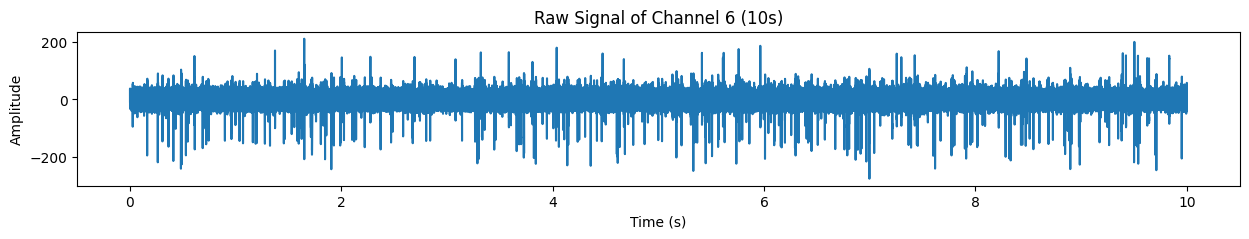

In [ ]:
with h5py.File("mearec_test_10s.h5", "r") as f:
    # Access the recordings dataset
    recordings = f['recordings'][:]  # This reads the entire dataset into a NumPy array

# recordings is now a NumPy array of shape (320000, 32) 32kHz, 10s, 32 channels
print(recordings.shape)
print(recordings.dtype)

fs = 32000 # sampling freq 32kHz
duration = 10 # 10s
n = fs * duration
t = np.linspace(0, duration, n)
y = recordings[:,6] # select channel 6 with obvious signal (plot full traces w/ spikeinterface)

plt.figure(figsize=(15, 2))
plt.plot(t, y)
plt.title("Raw Signal of Channel 6 (10s)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

## Preprocessing

Text(0, 0.5, 'Amplitude')

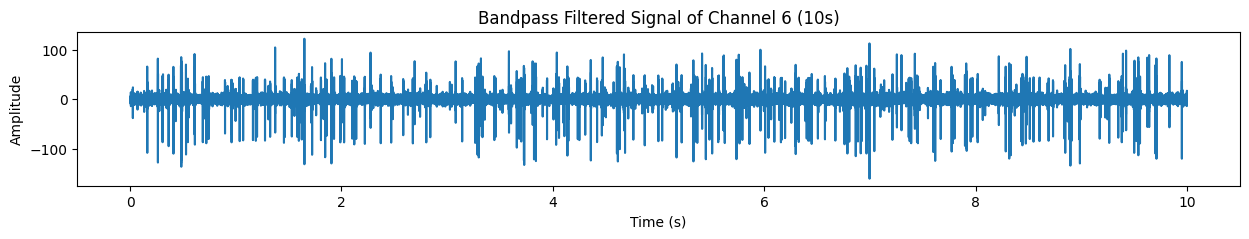

In [ ]:
# --- Preprocessing Step 1: Bandpass Filter (e.g., 300–6000 Hz) ---
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    return butter(order, [low, high], btype='band')

def bandpass_filter(data, lowcut=300, highcut=1200, fs=32000, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data, axis=0)

y_fil = bandpass_filter(y)

plt.figure(figsize=(15, 2))
plt.plot(t, y_fil)
plt.title("Bandpass Filtered Signal of Channel 6 (10s)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

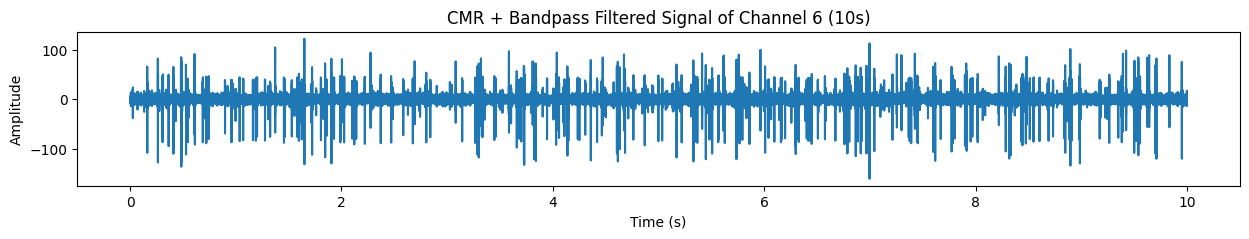

In [ ]:
# --- Preprocessing Step 2: Common Median Reference (CMR) ---
def common_median_reference(data):
    median = np.median(data, axis=0, keepdims=True)
    return data - median

y_cmr = common_median_reference(y_fil)

plt.figure(figsize=(15, 2))
plt.plot(t, y_cmr)
plt.title("CMR + Bandpass Filtered Signal of Channel 6 (10s)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

## Visualize original segment and manually sparse sample

(32000,)


Text(0, 0.5, 'y')

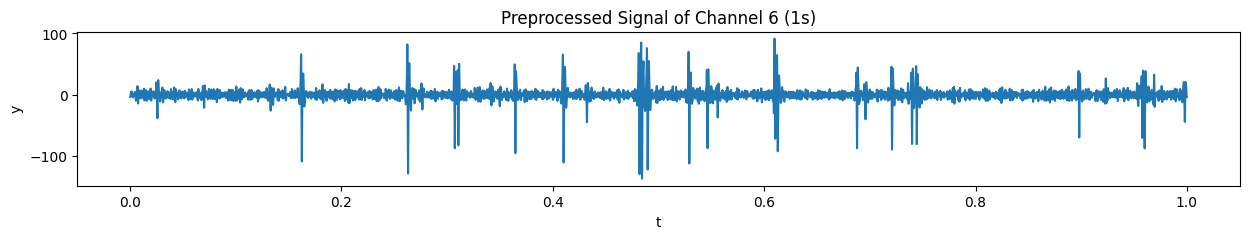

In [ ]:
# Enlarge to 1s window and plot spectral domain
duration = 1 # 1s
n = fs * duration
t = np.linspace(0, duration, n)
y = y_cmr[0:n]
print(y.shape)

plt.figure(figsize=(15, 2))
plt.plot(t, y)
plt.title("Preprocessed Signal of Channel 6 (1s)")
plt.xlabel("t")
plt.ylabel("y")

Text(0, 0.5, 'yt')

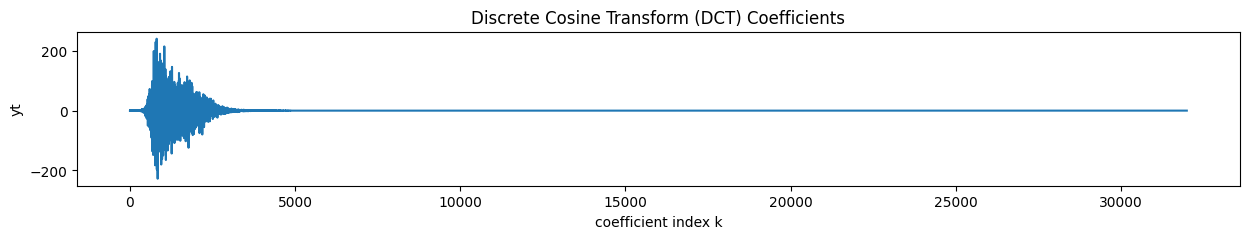

In [ ]:
yt = spfft.dct(y, norm='ortho')

plt.figure(figsize=(15, 2))
plt.plot(yt)
plt.title("Discrete Cosine Transform (DCT) Coefficients")
plt.xlabel('coefficient index k')
plt.ylabel('yt')

Text(0, 0.5, 'y_samp')

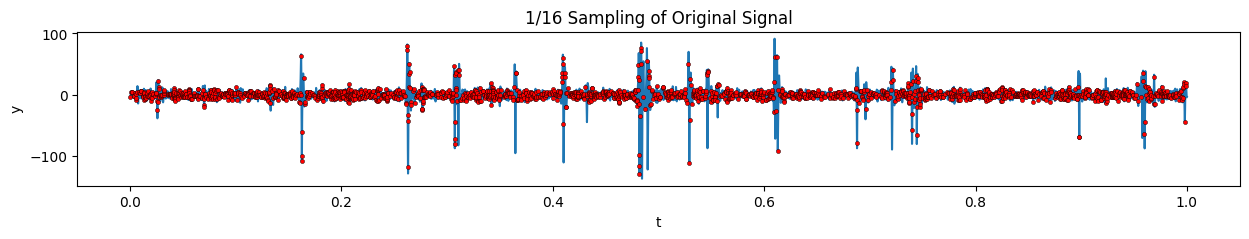

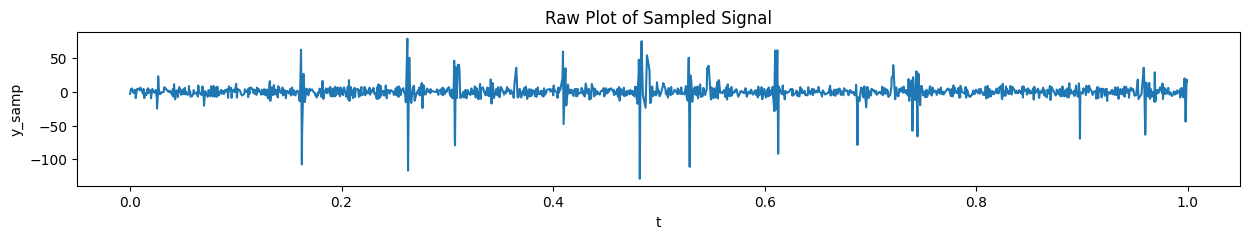

In [ ]:
# extract small sample of signal
m = int(n/16) # 1/16 sample
ri = np.random.choice(n, m, replace=False) # random sample of indices
ri.sort() # sorting not strictly necessary, but convenient for plotting
t2 = t[ri]
y2 = y[ri]

plt.figure(figsize=(15, 2))
plt.plot(t, y)
plt.plot(t2, y2, 'o', markersize=3, markerfacecolor='red', markeredgecolor='black', markeredgewidth=0.3)
plt.title('1/16 Sampling of Original Signal')
plt.xlabel('t')
plt.ylabel('y')

plt.figure(figsize=(15, 2))
plt.plot(t2, y2)
plt.title('Raw Plot of Sampled Signal')
plt.xlabel('t')
plt.ylabel('y_samp')

In [ ]:
# create idct matrix operator
A = spfft.idct(np.identity(n), norm='ortho', axis=0) # A: the inverse DCT matrix
print(A.shape)
A = A[ri]
print(A.shape)

(32000, 32000)
(2000, 32000)


In [ ]:
# do L1 optimization
vx = cvx.Variable(n) # the DCT coeff vector to solve for
print(vx.shape)
objective = cvx.Minimize(cvx.norm(vx, 1)) # minimize L1 norm - promote sparsity
constraints = [A*vx == y2] # exactly match known sampled values
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True) # the optimal value of the objective function (L1 norm)

(32000,)
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 19 12:31:53 PM: Your problem has 32000 variables, 2000 constraints, and 0 parameters.
(CVXPY) May 19 12:31:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 19 12:31:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 19 12:31:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 19 12:31:53 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 19 12:31:53 PM: Compiling problem (target sol

/usr/local/lib/python3.11/dist-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) May 19 12:32:50 PM: Applying reduction CLARABEL
(CVXPY) May 19 12:33:23 PM: Finished problem compilation (took 8.993e+01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) May 19 12:33:23 PM: Invoking solver CLARABEL  to obtain a solution.
-------------------------------------------------------------
           Clarabel.rs v0.10.0  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 64000
  constraints   = 66000
  nnz(P)        = 0
  nnz(A)        = 64127491
  cones (total) = 2
    :        Zero = 1,  numel = 2000
    : Nonnegative = 1,  numel = 64000

settings:
  linear algebra: d

Text(0, 0.5, 'y_samp')

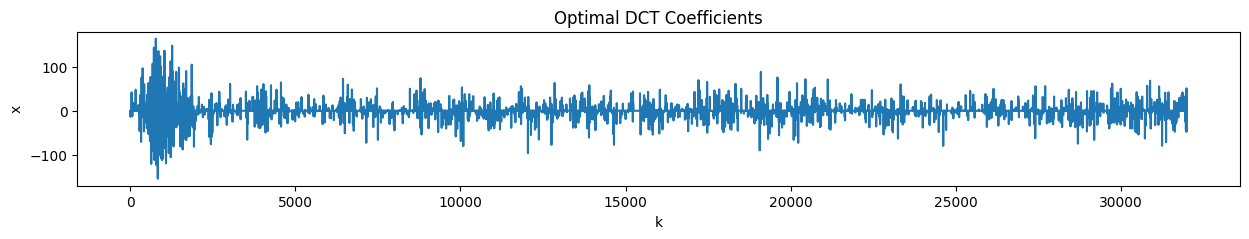

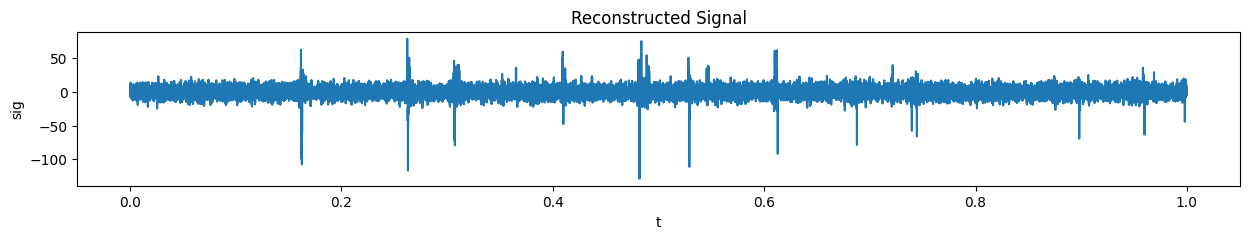

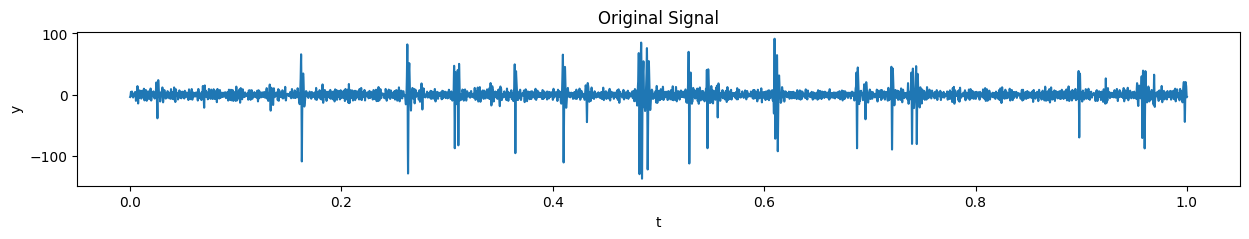

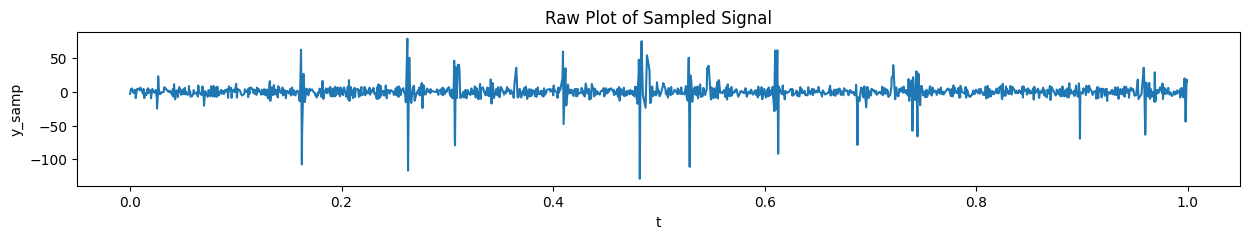

In [ ]:
# reconstruct signal
x = np.array(vx.value) # x: optimal DCT coefficients
x = np.squeeze(x) # clean up unnecessary dimensions
sig = spfft.idct(x, norm='ortho', axis=0) # inverse DCT (spectral > temporal domain)

plt.figure(figsize=(15, 2))
plt.plot(x)
plt.title("Optimal DCT Coefficients")
plt.xlabel('k')
plt.ylabel('x')
plt.figure(figsize=(15, 2))
plt.plot(t, sig)
plt.title("Reconstructed Signal")
plt.xlabel('t')
plt.ylabel('sig')
plt.figure(figsize=(15, 2))
plt.plot(t, y)
plt.title("Original Signal")
plt.xlabel('t')
plt.ylabel('y')
plt.figure(figsize=(15, 2))
plt.plot(t2, y2)
plt.title('Raw Plot of Sampled Signal')
plt.xlabel('t')
plt.ylabel('y_samp')

## Read with se.read_mearec

In [ ]:
!pip install MEArec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 93.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
recording, sorting_true = se.read_mearec("mearec_test_10s.h5")

Text(0.5, 1.0, 'Raw Voltage traces')

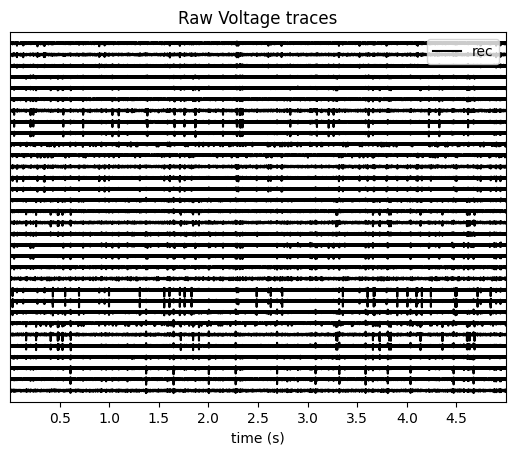

In [ ]:
w_ts = sw.plot_traces(recording, time_range=(0, 5))
plt.title('Raw Voltage traces')

Text(0.5, 1.0, 'Preprocessed Voltage traces')

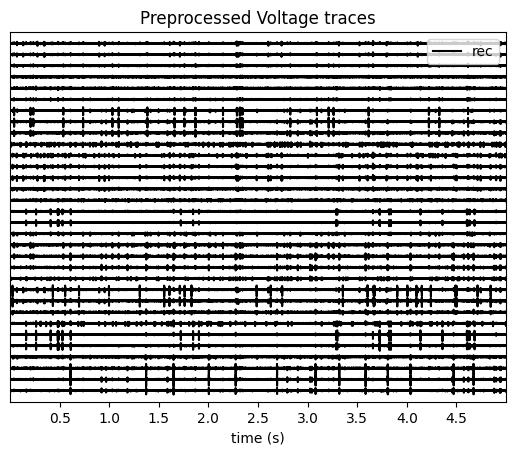

In [ ]:
recording_f = spre.bandpass_filter(recording, freq_min=300, freq_max=1200)
recording_cmr = spre.common_reference(recording_f, reference="global", operator="median")
w_ts_pre = sw.plot_traces(recording_cmr, time_range=(0, 5))
plt.title('Preprocessed Voltage traces')

In [ ]:
print(recording_cmr)

CommonReferenceRecording: 32 channels - 32.0kHz - 1 segments - 320,000 samples - 10.00s 
                          float32 dtype - 39.06 MiB
